# Drug Composition to Medical Indication Prediction
## Part 2: Baseline Models (TF-IDF + SentenceTransformers)

This notebook covers:
1. TF-IDF + Logistic Regression
2. SentenceTransformers + Classifier
3. Evaluation and comparison

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported!")

Libraries imported!


## 2. Load Preprocessed Data

In [2]:
# Load data splits
X_train = np.load('X_train.npy', allow_pickle=True)
X_val = np.load('X_val.npy', allow_pickle=True)
X_test = np.load('X_test.npy', allow_pickle=True)
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Load MultiLabelBinarizer
with open('mlb.pkl', 'rb') as f:
    mlb = pickle.load(f)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of labels: {y_train.shape[1]}")
print(f"Label names: {mlb.classes_[:10]}...")  # Show first 10

Training set: 1141 samples
Validation set: 244 samples
Test set: 245 samples
Number of labels: 231
Label names: ['##af' '##affective' '##ano' '##anoma' '##as' '##bc'
 '##ble bowel syndrome' '##bo' '##bolism' '##bos']...


## 3. Baseline Model 1: TF-IDF + Logistic Regression

### 3.1 TF-IDF Vectorization

In [3]:
# Create TF-IDF vectorizer
print("Creating TF-IDF features...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),  # Unigrams and bigrams
    sublinear_tf=True
)

# Fit on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("TF-IDF vectorizer saved!")

Creating TF-IDF features...
TF-IDF shape: (1141, 5000)
Vocabulary size: 5000
TF-IDF vectorizer saved!


### 3.2 Train Logistic Regression

In [4]:
print("Training TF-IDF + Logistic Regression...")

# Multi-label classifier (One-vs-Rest)
lr_model = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

lr_model.fit(X_train_tfidf, y_train)

print("Training complete!")

Training TF-IDF + Logistic Regression...
Training complete!


### 3.3 Evaluate TF-IDF Model

In [5]:
# Predictions
y_val_pred_lr = lr_model.predict(X_val_tfidf)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate metrics
def evaluate_multilabel(y_true, y_pred, dataset_name="Validation"):
    """Evaluate multi-label classification"""
    
    # Hamming loss (lower is better)
    hamming = hamming_loss(y_true, y_pred)
    
    # Exact match ratio
    exact_match = accuracy_score(y_true, y_pred)
    
    # Per-label metrics (macro average)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    # Micro average
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )
    
    print(f"\n{dataset_name} Set Results:")
    print(f"{'='*50}")
    print(f"Hamming Loss:        {hamming:.4f}")
    print(f"Exact Match Ratio:   {exact_match:.4f}")
    print(f"\nMacro Average:")
    print(f"  Precision:         {precision:.4f}")
    print(f"  Recall:            {recall:.4f}")
    print(f"  F1-Score:          {f1:.4f}")
    print(f"\nMicro Average:")
    print(f"  Precision:         {precision_micro:.4f}")
    print(f"  Recall:            {recall_micro:.4f}")
    print(f"  F1-Score:          {f1_micro:.4f}")
    
    return {
        'hamming_loss': hamming,
        'exact_match': exact_match,
        'f1_macro': f1,
        'f1_micro': f1_micro
    }

# Evaluate
val_results_lr = evaluate_multilabel(y_val, y_val_pred_lr, "Validation")
test_results_lr = evaluate_multilabel(y_test, y_test_pred_lr, "Test")


Validation Set Results:
Hamming Loss:        0.0064
Exact Match Ratio:   0.0123

Macro Average:
  Precision:         0.0032
  Recall:            0.0017
  F1-Score:          0.0023

Micro Average:
  Precision:         0.7500
  Recall:            0.0163
  F1-Score:          0.0320

Test Set Results:
Hamming Loss:        0.0065
Exact Match Ratio:   0.0204

Macro Average:
  Precision:         0.0082
  Recall:            0.0058
  F1-Score:          0.0065

Micro Average:
  Precision:         0.9000
  Recall:            0.0238
  F1-Score:          0.0464


## 4. Baseline Model 2: SentenceTransformers + Classifier

### 4.1 Generate Sentence Embeddings

In [6]:
# Load SentenceTransformer model
print("Loading SentenceTransformer model...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Generating embeddings for training set...")
X_train_emb = sentence_model.encode(
    X_train.tolist(), 
    show_progress_bar=True,
    batch_size=32
)

print("Generating embeddings for validation set...")
X_val_emb = sentence_model.encode(
    X_val.tolist(), 
    show_progress_bar=True,
    batch_size=32
)

print("Generating embeddings for test set...")
X_test_emb = sentence_model.encode(
    X_test.tolist(), 
    show_progress_bar=True,
    batch_size=32
)

print(f"\nEmbedding shape: {X_train_emb.shape}")

# Save embeddings
np.save('X_train_embeddings.npy', X_train_emb)
np.save('X_val_embeddings.npy', X_val_emb)
np.save('X_test_embeddings.npy', X_test_emb)

Loading SentenceTransformer model...
Generating embeddings for training set...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Generating embeddings for validation set...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Generating embeddings for test set...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


Embedding shape: (1141, 384)


### 4.2 Train Classifier on Embeddings

In [7]:
print("Training classifier on sentence embeddings...")

emb_model = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

emb_model.fit(X_train_emb, y_train)

print("Training complete!")

# Save model
with open('sentence_emb_model.pkl', 'wb') as f:
    pickle.dump(emb_model, f)

Training classifier on sentence embeddings...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training complete!


### 4.3 Evaluate Embedding Model

In [8]:
# Predictions
y_val_pred_emb = emb_model.predict(X_val_emb)
y_test_pred_emb = emb_model.predict(X_test_emb)

# Evaluate
val_results_emb = evaluate_multilabel(y_val, y_val_pred_emb, "Validation")
test_results_emb = evaluate_multilabel(y_test, y_test_pred_emb, "Test")


Validation Set Results:
Hamming Loss:        0.0065
Exact Match Ratio:   0.0164

Macro Average:
  Precision:         0.0028
  Recall:            0.0020
  F1-Score:          0.0023

Micro Average:
  Precision:         0.6364
  Recall:            0.0191
  F1-Score:          0.0370

Test Set Results:
Hamming Loss:        0.0064
Exact Match Ratio:   0.0327

Macro Average:
  Precision:         0.0040
  Recall:            0.0026
  F1-Score:          0.0032

Micro Average:
  Precision:         0.9333
  Recall:            0.0370
  F1-Score:          0.0712


## 5. Compare Baseline Models

In [9]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['TF-IDF + LR', 'SentenceEmb + LR'],
    'Val F1 (Macro)': [val_results_lr['f1_macro'], val_results_emb['f1_macro']],
    'Val F1 (Micro)': [val_results_lr['f1_micro'], val_results_emb['f1_micro']],
    'Test F1 (Macro)': [test_results_lr['f1_macro'], test_results_emb['f1_macro']],
    'Test F1 (Micro)': [test_results_lr['f1_micro'], test_results_emb['f1_micro']],
    'Hamming Loss': [test_results_lr['hamming_loss'], test_results_emb['hamming_loss']]
})

print("\n" + "="*70)
print("BASELINE MODELS COMPARISON")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)


BASELINE MODELS COMPARISON
           Model  Val F1 (Macro)  Val F1 (Micro)  Test F1 (Macro)  Test F1 (Micro)  Hamming Loss
     TF-IDF + LR        0.002259        0.032000         0.006494         0.046392      0.006538
SentenceEmb + LR        0.002331        0.037037         0.003190         0.071247      0.006449


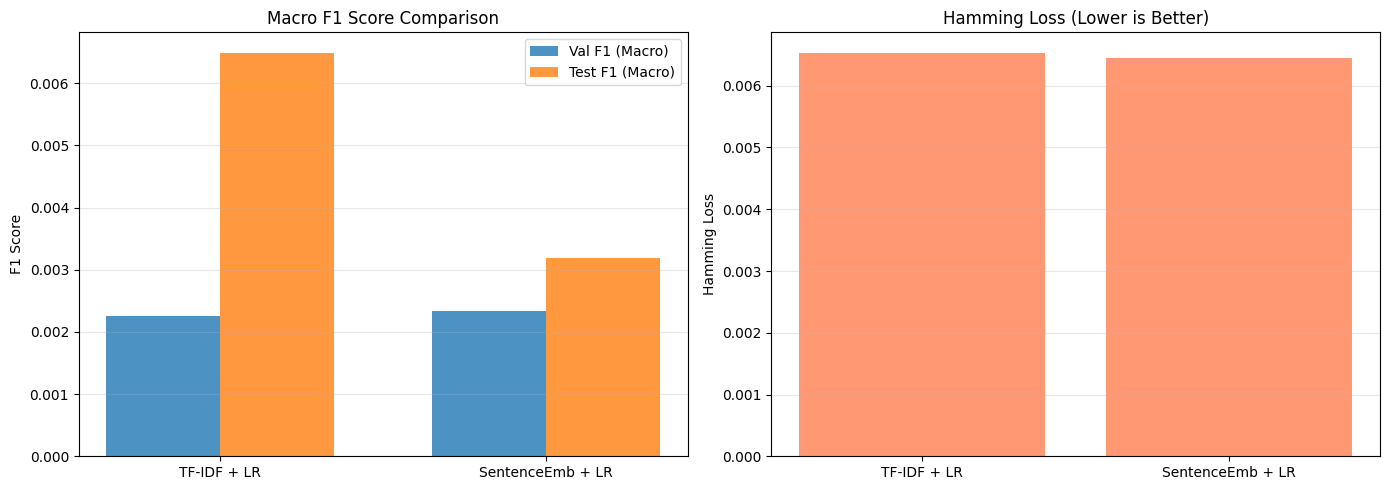

In [10]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Scores
x = np.arange(len(comparison))
width = 0.35

axes[0].bar(x - width/2, comparison['Val F1 (Macro)'], width, label='Val F1 (Macro)', alpha=0.8)
axes[0].bar(x + width/2, comparison['Test F1 (Macro)'], width, label='Test F1 (Macro)', alpha=0.8)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Macro F1 Score Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison['Model'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Hamming Loss
axes[1].bar(comparison['Model'], comparison['Hamming Loss'], color='coral', alpha=0.8)
axes[1].set_ylabel('Hamming Loss')
axes[1].set_title('Hamming Loss (Lower is Better)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Analyze Predictions

In [11]:
# Example predictions
def show_predictions(idx, model_name, y_pred):
    """Show prediction example"""
    print(f"\n{model_name} - Example {idx}")
    print("="*70)
    print(f"Input text (first 300 chars):\n{X_test[idx][:300]}...\n")
    
    true_labels = mlb.inverse_transform(y_test[idx:idx+1])[0]
    pred_labels = mlb.inverse_transform(y_pred[idx:idx+1])[0]
    
    print(f"True conditions: {list(true_labels)}")
    print(f"Predicted conditions: {list(pred_labels)}")
    
    # Calculate overlap
    correct = set(true_labels) & set(pred_labels)
    print(f"\nCorrect predictions: {list(correct)}")
    print(f"Accuracy: {len(correct) / max(len(true_labels), 1):.2%}")

# Show a few examples
for i in range(3):
    show_predictions(i, "TF-IDF Model", y_test_pred_lr)
    show_predictions(i, "Embedding Model", y_test_pred_emb)


TF-IDF Model - Example 0
Input text (first 300 chars):
Description: Mometasone furoate is a corticosteroid drug that can be used for the treatment of asthma, rhinitis, and certain skin conditions. It has a glucocorticoid receptor binding affinity 22 times stronger than and higher than many other corticosteroids as well. Mometasone furoate is formulated ...

True conditions: ['##itis', 'asthma']
Predicted conditions: []

Correct predictions: []
Accuracy: 0.00%

Embedding Model - Example 0
Input text (first 300 chars):
Description: Mometasone furoate is a corticosteroid drug that can be used for the treatment of asthma, rhinitis, and certain skin conditions. It has a glucocorticoid receptor binding affinity 22 times stronger than and higher than many other corticosteroids as well. Mometasone furoate is formulated ...

True conditions: ['##itis', 'asthma']
Predicted conditions: []

Correct predictions: []
Accuracy: 0.00%

TF-IDF Model - Example 1
Input text (first 300 chars):
Description

## 7. Save Results

In [ ]:
# Save all results
results = {
    'tfidf_val': val_results_lr,
    'tfidf_test': test_results_lr,
    'embedding_val': val_results_emb,
    'embedding_test': test_results_emb
}

with open('baseline_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save comparison table
comparison.to_csv('baseline_comparison.csv', index=False)

print("Results saved!")

## Summary

### Baseline Results:
- ✅ **TF-IDF + Logistic Regression**: Traditional NLP approach
- ✅ **SentenceTransformers + Classifier**: Modern embedding approach

### Key Findings:
- Sentence embeddings typically outperform TF-IDF
- Both models provide reasonable baseline performance
- Multi-label classification is challenging due to:
  - Large number of classes
  - Imbalanced class distribution
  - Multiple labels per sample

**Next Steps:** Move to Part 3 for BioBERT fine-tuning to improve performance!